In [1]:
# --------------------------------------------
# Blame : Raghul Ranganathan  & Saravanan Muthuramalingam
# Assignment : Gesture Recognition
# Description : Gesture Reconization for a Tv company to improve the controls
# Language : Python3
# Draft #: 1
# Start Date : 16th Jun 2021
# End Date : 28th Jun 2021
# ----------------------------------------------

# <font color="Blue"> Gesture Recognition

#### <font color="orange"> Problem Statement

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [2]:
#importing required Libraries

import numpy as np
import os
from imageio import imread
from scipy import misc
import datetime
import os
from PIL import Image
from skimage.transform import resize

We set the random seed so that the results don't vary drastically.

In [3]:
#Using seed to eliminate huge change in outputs

np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [4]:
#Assiging the Path of train_doc and Val_doc

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

# Assigning Batch Size as 64
batch_size = 64

### <font color="orange"> Visualizing Random Datasets

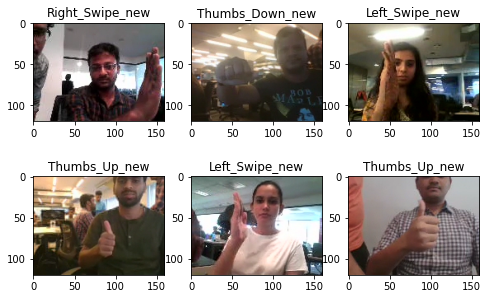

In [5]:
# Visualizing Random Images

import matplotlib.pyplot as plt
%matplotlib inline

#Assigining Height and Width of the images
image_width = 100
image_height = 100

plt.figure(figsize=(8,8))
for i in range(6):
    sample_im_path = '/home/datasets/Project_data/train'+'/'+ train_doc[i].split(';')[0]
    ax=plt.subplot(3, 3, i+1)
    plt.title(train_doc[i].split(';')[1])
    plt.imshow(imread(sample_im_path+'/'+os.listdir(sample_im_path)[0])) 

## <font color="orange"> Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
# Function to Crop and Resize the images

def cropAndResize (image, WIDTH_DIMENSION, HEIGHT_DIMENSION): 
    # CROPPING (making aspect ratio same)
    if abs(image.shape [0]-image.shape [1])%2==0 and image.shape[0]!=image.shape[1]: 
        dimension_diff=abs(image.shape [0]-image.shape[1])
        cropping_ratio=dimension_diff//2
        if image.shape[0]>image.shape[1]:
            image=image[cropping_ratio:image.shape[0]-cropping_ratio,:,:] 
        elif image.shape[0]<image.shape[1]:
            image=image[:,cropping_ratio: image.shape[1]-cropping_ratio,:]

    # RESIZING
    if image.shape[0]>HEIGHT_DIMENSION or image.shape[1]>WIDTH_DIMENSION: 
        image = resize(image, (HEIGHT_DIMENSION, WIDTH_DIMENSION))
    return image

In [7]:
#Generator function to fetch images as batches to use the memory efficiently

def generator(source_path, folder_list, batch_size):
    #create a list of image numbers you want to use for a particular video
    img_idx = [ 5, 7, 9, 11, 13, 15, 16, 18, 21, 23, 25] 
    x = len(img_idx)
    y = image_width
    z = image_height

    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # crop the images and resize them. Note that the images are of 2 different shape 
                    # and the conv3D will throw error if the inputs in a batch have different shapes
                    image = cropAndResize(image, image_width, image_height)
                     
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
            
        # write the code for the remaining data points which are left after full batches
        # finding the remaining count of the images
        other_images = len(folder_list)%batch_size
        # adding those images as the new batch
        batch += 1
        if(other_images!=0):
            # creating the batch data with remainind data as batch size
            batch_data = np.zeros((other_images,len(img_idx),y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images
            batch_labels = np.zeros((other_images,5)) # batch_labels is the one hot representation of the output
            for folder in range(other_images): # iterate over the batch_size
                # read all the images in the folder
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*other_images)].split(';')[0])
                # Iterate over the frames/images of a folder to read them in
                for idx,item in enumerate(img_idx): 
                    # Get the image value
                    image = imread(source_path+'/'+ t[folder + (batch*other_images)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                   
                    # crop and resize the image using the custom defined function
                    image = cropAndResize(image, image_width, image_height)
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*other_images)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
#Variable Declaration
curr_dt_time = datetime.datetime.now()

train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# number of epochs
num_epochs = 30 
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## <font color="orange"> Model Creation
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
#Model Creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

# Since we have 5 controls
num_classes = 5

cnn =Sequential()

# We are using time distributed with the COnv 2D and MaxPooling2D
cnn.add(TimeDistributed(Conv2D(32, (3, 3), padding='same'), input_shape=(11, image_width,image_height,3)))
cnn.add(Activation('relu'))
# standardize the inputs to a network and fast the training
cnn.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
cnn.add(BatchNormalization())

cnn.add(TimeDistributed(Conv2D(64, (3, 3))))
cnn.add(Activation('relu'))
cnn.add(TimeDistributed(MaxPooling2D(pool_size=(3, 3))))
# We are giving the minimum dropout for the output from the first few layers to avoid lossing many features
cnn.add(BatchNormalization())

cnn.add(TimeDistributed(MaxPooling2D(pool_size=(3, 3))))
cnn.add(Dropout(0.25))

# Maintaining the same 32, 2, 2 with more dropout for the middle level layers
cnn.add(TimeDistributed(Conv2D(128, (3, 3), padding='same')))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.3))

cnn.add(TimeDistributed(Conv2D(256, (3, 3), padding='same')))
cnn.add(Activation('relu'))
cnn.add(TimeDistributed(MaxPooling2D(pool_size=(3, 3))))
cnn.add(Dropout(0.3))

cnn.add(TimeDistributed(Flatten()))
cnn.add(Dropout(0.5))
cnn.add(GRU(256, return_sequences=False, dropout=0.5))
cnn.add(Dense(128,kernel_regularizer=l2(0.01)))
cnn.add(Activation('relu'))
cnn.add(Dense(num_classes))
cnn.add(Activation('softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

### <font color="orange"> Optimizer 

In [10]:
# Adam Optimizer
optimiser = 'adam'
# Using categorical_accuracy as the metrics
cnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 11, 100, 100, 32)  896       
_________________________________________________________________
activation (Activation)      (None, 11, 100, 100, 32)  0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 11, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 11, 48, 48, 64)    18496     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 48, 48, 64)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 11, 16, 16, 64)    0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [11]:
#Train and Validation data 

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
#Hyperparamter value of learning rate and Monitoring the accuracy and loss in checkpoint

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# creating the checkpoints for the each epoch with the above metrics in the file name
# Adding the time differs the h5 file if they have same aove values

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', 
    patience=3, 
    factor=0.5, 
    min_lr=0.01)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [13]:
#condition based on the tr4ain sequence and validation sequnece
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

### <font color="orange"> Fitting the Model

In [14]:
#Fit the model
history = cnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 3.3118 - categorical_accuracy: 0.2293
Epoch 00001: saving model to model_init_2021-06-2810_55_14.393074/model-00001-3.31175-0.22926-3.19009-0.23000.h5
11/11 [==============================] - 52s 5s/step - loss: 3.3118 - categorical_accuracy: 0.2293 - val_loss: 3.1901 - val_categorical_accuracy: 0.2300
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 3.1316 - categorical_accuracy: 0.2760
Epoch 00002: saving model to model_init_2021-06-2810_55_14.393074/model-00002-3.13162-0.27602-3.24602-0.30000.h5
11/11 [==============================] - 51s 5s/step - loss: 3.1316 - categorical_accuracy: 0.2760 - val_loss: 3.2460 - val_categorical_accuracy: 0.3000
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 2.8002 - categorical_accuracy: 0.4027
Epoch 00003: saving model to model_init_2021-06-2810_55_14.393074/model-00

### <font color="orange"> Visualizing training results

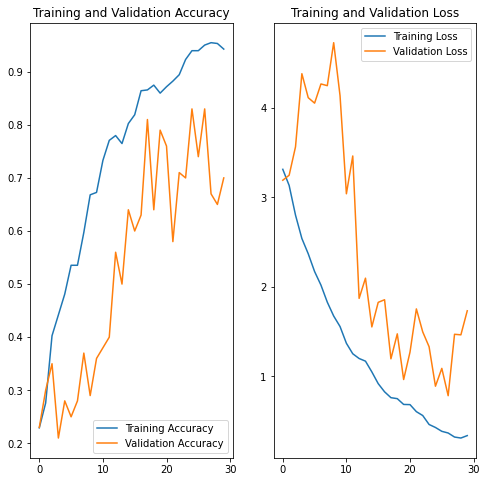

In [16]:
#Visualizing the training results and validation results
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=30
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()